<a href="https://colab.research.google.com/github/cl9612023/Journals-Paper/blob/main/Aberration_predict(phase_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
%tensorflow_version 1.x
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, Activation,concatenate
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.layers.convolutional import  AveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import gc
from math import pi
import random
#Google Cloud permissions
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
#(x,y) to (r,theta)
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

#定義32階係數的名稱a1-a32
column_names = []
for i in range(0,32,1):
  i = str(i+1)
  a = 'a'+i
  column_names.append(a)
print(column_names)

['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a20', 'a21', 'a22', 'a23', 'a24', 'a25', 'a26', 'a27', 'a28', 'a29', 'a30', 'a31', 'a32']


In [34]:
#產生相位資訊
def phase(rho,theta,c):
    phi =c[0,0]*1 \
            +c[0,1]* 2 * rho * np.sin(theta) \
            +c[0,2]* 2 * rho * np.cos(theta)\
            +c[0,3]*np.sqrt(6)*rho**2 * np.sin(2*theta)\
            +c[0,4]*np.sqrt(3)*(2*rho**2 - 1)\
            +c[0,5]*np.sqrt(6)*rho**2 * np.cos(2*theta)\
            +c[0,6]*np.sqrt(8)*rho**3 * np.sin(3*theta)\
            +c[0,7]*np.sqrt(8)*(3*rho**3 - 2*rho) * np.sin(theta)\
            +c[0,8]*np.sqrt(8)*(3*rho**3 - 2*rho) * np.cos(theta)\
            +c[0,9]*np.sqrt(8)*rho**3 * np.cos(3*theta)\
            +c[0,10]*np.sqrt(10)*rho**4* np.sin(4*theta)\
            +c[0,11]*np.sqrt(10)*(4*rho**4 - 3*rho**2) * np.sin(2*theta)\
            +c[0,12]*np.sqrt(5)*(6*rho**4 - 6*rho**2 + 1)\
            +c[0,13]*np.sqrt(10)*(4*rho**4 - 3*rho**2) * np.cos(2*theta)\
            +c[0,14]*np.sqrt(10)*rho**4* np.cos(4*theta)\
            +c[0,15]*np.sqrt(12)*rho**5* np.sin(5*theta)\
            +c[0,16]*np.sqrt(12)*(5*rho**5 - 4*rho**3) * np.sin(3*theta)\
            +c[0,17]*np.sqrt(12)*(10*rho**5 - 12*rho**3 + 3*rho) * np.sin(theta)\
            +c[0,18]*np.sqrt(12)*(10*rho**5 - 12*rho**3 + 3*rho) * np.cos(theta)\
            +c[0,19]*np.sqrt(12)*(5*rho**5 - 4*rho**3) * np.cos(3*theta)\
            +c[0,20]*np.sqrt(12)*rho**5* np.cos(5*theta)\
            +c[0,21]*np.sqrt(14)*rho**6* np.sin(6*theta)\
            +c[0,22]*np.sqrt(14)*(6*rho**6 - 5*rho**4) * np.sin(4*theta)\
            +c[0,23]*np.sqrt(14)*(15*rho**6 - 20*rho**4 + 6*rho**2) * np.sin(2*theta)\
            +c[0,24]*np.sqrt(7)*(20*rho**6 - 30*rho**4 + 12*rho**2 - 1)\
            +c[0,25]*np.sqrt(14)*(15*rho**6 - 20*rho**4 + 6*rho**2) * np.cos(2*theta)\
            +c[0,26]*np.sqrt(14)*(6*rho**6 - 5*rho**4) * np.cos(4*theta)\
            +c[0,27]*np.sqrt(14)*rho**6* np.cos(6*theta)\
            +c[0,28]*4 * rho**7* np.sin(7*theta)\
            +c[0,29]*4 *(7*rho**7 - 6*rho**5) * np.sin(5*theta)\
            +c[0,30]*4 *(21*rho**7 - 30*rho**5 + 10*rho**3) * np.sin(3*theta)\
            +c[0,31]*4 *(35*rho**7 - 60*rho**5 + 30*rho**3 - 4*rho) * np.sin(theta)
    return phi

In [35]:
#GoogleNet架構
def Conv2d_BN(x, nb_filter, kernel_size, padding='same', strides=(1, 1)):
    x = Conv2D(nb_filter, kernel_size, padding=padding, strides=strides, activation='tanh')(x)
    return x

def Inception(x, nb_filter):
    branch1x1 = Conv2d_BN(x, nb_filter, (1, 1), padding='same', strides=(1, 1))

    branch3x3 = Conv2d_BN(x, nb_filter, (1, 1), padding='same', strides=(1, 1))
    branch3x3 = Conv2d_BN(branch3x3, nb_filter, (1, 3), padding='same', strides=(1, 1))
    branch3x3 = Conv2d_BN(branch3x3, nb_filter, (3, 1), padding='same', strides=(1, 1))

    branch5x5 = Conv2d_BN(x, nb_filter, (1, 1), padding='same', strides=(1, 1))
    branch5x5 = Conv2d_BN(branch3x3, nb_filter, (1, 3), padding='same', strides=(1, 1))
    branch5x5 = Conv2d_BN(branch3x3, nb_filter, (3, 1), padding='same', strides=(1, 1))
    branch5x5 = Conv2d_BN(branch3x3, nb_filter, (1, 3), padding='same', strides=(1, 1))
    branch3x3 = Conv2d_BN(branch3x3, nb_filter, (3, 1), padding='same', strides=(1, 1))

    branchpool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    branchpool = Conv2d_BN(branchpool, nb_filter, (1, 1), padding='same', strides=(1, 1))

    x = concatenate([branch1x1, branch3x3, branch5x5, branchpool], axis=3)

    return x

inpt = Input(shape=(256, 256, 1))    
x = Conv2d_BN(inpt,64, (7, 7),  strides=(2, 2), padding='same')
x  = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x  = Conv2d_BN(x, 192, (3, 3), strides=(1, 1), padding='same')
x  = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x  = Inception(x, 64)  
x  = Inception(x, 120)  
x  = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x  = Inception(x, 128)  
x  = Inception(x, 128)
x  = Inception(x, 128)
x  = Inception(x, 132)  
x  = Inception(x, 208)  
x  = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
x  = Inception(x, 208)
x  = Inception(x, 256)  
x  = AveragePooling2D(pool_size=(7, 7), strides=(7, 7), padding='same')(x)
x = Flatten()(x)
x = Dense(2048, activation='tanh')(x)
x = Dense(1024, activation='tanh')(x)
x = Dense(1024, activation='tanh')(x)
x = Dense(32, activation='linear')(x)
model = Model(inpt, x, name='inception')
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=0.00001), metrics=['accuracy'])
model.summary()

Model: "inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_553 (Conv2D)             (None, 128, 128, 64) 3200        input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_79 (MaxPooling2D) (None, 64, 64, 64)   0           conv2d_553[0][0]                 
__________________________________________________________________________________________________
conv2d_554 (Conv2D)             (None, 64, 64, 192)  110784      max_pooling2d_79[0][0]           
__________________________________________________________________________________________

In [36]:
num =500
a = np.linspace(-256, 255, 256)
xv,yv = np.meshgrid( a , a )
yv = yv*-1
rho,theta = cart2pol( xv , yv )
m =rho.max()*0.7
rho = rho/m
rho[rho>1]=np.nan
COE = np.zeros([num,32])
Y = np.zeros((num, 256, 256))
for i in tqdm(range(0,num,1)):
    c =(np.random.rand(1,32)*2-1)/2
    c = c.round(6)
    COE[i,:]=c
    phi=phase(rho,theta,c)
    phi[np.isnan(phi)] = 0
    Y[i] = phi

raw = pd.DataFrame(COE,columns=column_names)
Y=Y.reshape(num, 256, 256,1)
X_test, y_test = Y , raw

def train_batch_generator(ran):
    a = np.linspace(-256, 255, 256)
    xv,yv = np.meshgrid( a , a )
    yv = yv*-1
    rho,theta = cart2pol( xv , yv )
    m =rho.max()*0.7
    rho = rho/m
    rho[rho>1]=np.nan

    z = np.zeros([ran,32])
    X = np.zeros((ran, 256, 256))

    for i in tqdm(range(0,ran,1)):
        c =(np.random.rand(1,32)*2-1)/2
        c = c.round(6)
        z[i,:]=c
        phi=phase(rho,theta,c)
        phi[np.isnan(phi)] = 0
        X[i] = phi
    
    raw_dataset = pd.DataFrame(z,columns=column_names)
    X=X.reshape(ran, 256, 256,1)
    X_train, y_train = X , raw_dataset
    gc.collect()
    yield (X_train, y_train)

In [37]:
#訓練過程
weight_saver = ModelCheckpoint('/content/drive/My Drive/Masterpiece/modle/test.h5', monitor='val_loss', save_best_only=True,verbose=2)
earlystop = EarlyStopping(monitor='accuracy', patience=20,verbose=2)
rle = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=20,verbose=1,min_lr=1e-10)
NUM_EPOCHS = 10
history_all = {}
for i in range(NUM_EPOCHS):
    print('################{0} epochs#############'.format(i+1))
    for X_train, y_train in train_batch_generator(1000):
      history = model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  epochs= 20, batch_size=16,verbose=2,callbacks = [weight_saver,earlystop,rle])
      if len(history_all) == 0:
        history_all = {key: [] for key in history.history}
      for key in history_all:
        history_all[key].extend(history.history[key])


################1 epochs#############




Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 16s - loss: 0.0930 - accuracy: 0.0780 - val_loss: 0.0712 - val_accuracy: 0.1000

Epoch 00001: val_loss improved from inf to 0.07125, saving model to /content/drive/My Drive/Masterpiece/modle/test.h5
Epoch 2/20
 - 5s - loss: 0.0626 - accuracy: 0.1340 - val_loss: 0.0600 - val_accuracy: 0.1300

Epoch 00002: val_loss improved from 0.07125 to 0.05997, saving model to /content/drive/My Drive/Masterpiece/modle/test.h5
Epoch 3/20
 - 5s - loss: 0.0499 - accuracy: 0.1740 - val_loss: 0.0479 - val_accuracy: 0.1660

Epoch 00003: val_loss improved from 0.05997 to 0.04792, saving model to /content/drive/My Drive/Masterpiece/modle/test.h5
Epoch 4/20
 - 5s - loss: 0.0390 - accuracy: 0.2070 - val_loss: 0.0381 - val_accuracy: 0.1800

Epoch 00004: val_loss improved from 0.04792 to 0.03813, saving model to /content/drive/My Drive/Masterpiece/modle/test.h5
Epoch 5/20
 - 5s - loss: 0.0306 - accuracy: 0.2430 - val_loss: 0.0313 - val_accuracy: 0.21


Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 5s - loss: 0.0064 - accuracy: 0.3900 - val_loss: 0.0066 - val_accuracy: 0.4060

Epoch 00001: val_loss improved from 0.00675 to 0.00656, saving model to /content/drive/My Drive/Masterpiece/modle/test.h5
Epoch 2/20
 - 5s - loss: 0.0054 - accuracy: 0.4060 - val_loss: 0.0062 - val_accuracy: 0.4000

Epoch 00002: val_loss improved from 0.00656 to 0.00620, saving model to /content/drive/My Drive/Masterpiece/modle/test.h5
Epoch 3/20
 - 5s - loss: 0.0047 - accuracy: 0.4560 - val_loss: 0.0057 - val_accuracy: 0.3980

Epoch 00003: val_loss improved from 0.00620 to 0.00568, saving model to /content/drive/My Drive/Masterpiece/modle/test.h5
Epoch 4/20
 - 5s - loss: 0.0042 - accuracy: 0.4710 - val_loss: 0.0053 - val_accuracy: 0.3880

Epoch 00004: val_loss improved from 0.00568 to 0.00527, saving model to /content/drive/My Drive/Masterpiece/modle/test.h5
Epoch 5/20
 - 5s - loss: 0.0039 - accuracy: 0.4780 - val_loss: 0.0050 - val_accuracy: 0.


Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 5s - loss: 0.0036 - accuracy: 0.4740 - val_loss: 0.0039 - val_accuracy: 0.4620

Epoch 00001: val_loss did not improve from 0.00351
Epoch 2/20
 - 5s - loss: 0.0033 - accuracy: 0.4860 - val_loss: 0.0034 - val_accuracy: 0.4820

Epoch 00002: val_loss improved from 0.00351 to 0.00339, saving model to /content/drive/My Drive/Masterpiece/modle/test.h5
Epoch 3/20
 - 5s - loss: 0.0028 - accuracy: 0.5310 - val_loss: 0.0032 - val_accuracy: 0.4820

Epoch 00003: val_loss improved from 0.00339 to 0.00324, saving model to /content/drive/My Drive/Masterpiece/modle/test.h5
Epoch 4/20
 - 5s - loss: 0.0025 - accuracy: 0.5530 - val_loss: 0.0032 - val_accuracy: 0.4880

Epoch 00004: val_loss improved from 0.00324 to 0.00319, saving model to /content/drive/My Drive/Masterpiece/modle/test.h5
Epoch 5/20
 - 5s - loss: 0.0022 - accuracy: 0.5430 - val_loss: 0.0031 - val_accuracy: 0.4760

Epoch 00005: val_loss improved from 0.00319 to 0.00313, saving mo


Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 5s - loss: 0.0026 - accuracy: 0.5250 - val_loss: 0.0028 - val_accuracy: 0.4880

Epoch 00001: val_loss did not improve from 0.00241
Epoch 2/20
 - 5s - loss: 0.0023 - accuracy: 0.5470 - val_loss: 0.0025 - val_accuracy: 0.5040

Epoch 00002: val_loss did not improve from 0.00241
Epoch 3/20
 - 5s - loss: 0.0020 - accuracy: 0.5640 - val_loss: 0.0023 - val_accuracy: 0.5140

Epoch 00003: val_loss improved from 0.00241 to 0.00231, saving model to /content/drive/My Drive/Masterpiece/modle/test.h5
Epoch 4/20
 - 5s - loss: 0.0018 - accuracy: 0.5730 - val_loss: 0.0023 - val_accuracy: 0.5280

Epoch 00004: val_loss improved from 0.00231 to 0.00231, saving model to /content/drive/My Drive/Masterpiece/modle/test.h5
Epoch 5/20
 - 5s - loss: 0.0016 - accuracy: 0.5790 - val_loss: 0.0023 - val_accuracy: 0.5180

Epoch 00005: val_loss improved from 0.00231 to 0.00226, saving model to /content/drive/My Drive/Masterpiece/modle/test.h5
Epoch 6/20
 - 


Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 5s - loss: 0.0021 - accuracy: 0.5520 - val_loss: 0.0022 - val_accuracy: 0.5200

Epoch 00001: val_loss did not improve from 0.00181
Epoch 2/20
 - 5s - loss: 0.0019 - accuracy: 0.5500 - val_loss: 0.0021 - val_accuracy: 0.5420

Epoch 00002: val_loss did not improve from 0.00181
Epoch 3/20
 - 5s - loss: 0.0016 - accuracy: 0.5720 - val_loss: 0.0020 - val_accuracy: 0.5360

Epoch 00003: val_loss did not improve from 0.00181
Epoch 4/20
 - 5s - loss: 0.0014 - accuracy: 0.5790 - val_loss: 0.0017 - val_accuracy: 0.5660

Epoch 00004: val_loss improved from 0.00181 to 0.00175, saving model to /content/drive/My Drive/Masterpiece/modle/test.h5
Epoch 5/20
 - 5s - loss: 0.0012 - accuracy: 0.5930 - val_loss: 0.0018 - val_accuracy: 0.5520

Epoch 00005: val_loss did not improve from 0.00175
Epoch 6/20
 - 5s - loss: 0.0011 - accuracy: 0.5960 - val_loss: 0.0017 - val_accuracy: 0.5720

Epoch 00006: val_loss improved from 0.00175 to 0.00173, saving


Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 5s - loss: 0.0017 - accuracy: 0.5910 - val_loss: 0.0018 - val_accuracy: 0.5580

Epoch 00001: val_loss did not improve from 0.00144
Epoch 2/20
 - 5s - loss: 0.0015 - accuracy: 0.6150 - val_loss: 0.0016 - val_accuracy: 0.5720

Epoch 00002: val_loss did not improve from 0.00144
Epoch 3/20
 - 5s - loss: 0.0012 - accuracy: 0.6230 - val_loss: 0.0016 - val_accuracy: 0.5760

Epoch 00003: val_loss did not improve from 0.00144
Epoch 4/20
 - 5s - loss: 0.0011 - accuracy: 0.6520 - val_loss: 0.0016 - val_accuracy: 0.5780

Epoch 00004: val_loss did not improve from 0.00144
Epoch 5/20
 - 5s - loss: 0.0010 - accuracy: 0.6430 - val_loss: 0.0015 - val_accuracy: 0.6140

Epoch 00005: val_loss did not improve from 0.00144
Epoch 6/20
 - 5s - loss: 8.6839e-04 - accuracy: 0.6760 - val_loss: 0.0015 - val_accuracy: 0.5940

Epoch 00006: val_loss did not improve from 0.00144
Epoch 7/20
 - 5s - loss: 8.1000e-04 - accuracy: 0.6660 - val_loss: 0.0013 - va


Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 5s - loss: 0.0014 - accuracy: 0.6000 - val_loss: 0.0014 - val_accuracy: 0.5900

Epoch 00001: val_loss did not improve from 0.00114
Epoch 2/20
 - 5s - loss: 0.0012 - accuracy: 0.6260 - val_loss: 0.0014 - val_accuracy: 0.5820

Epoch 00002: val_loss did not improve from 0.00114
Epoch 3/20
 - 5s - loss: 0.0010 - accuracy: 0.6540 - val_loss: 0.0012 - val_accuracy: 0.5900

Epoch 00003: val_loss did not improve from 0.00114
Epoch 4/20
 - 5s - loss: 8.7327e-04 - accuracy: 0.6560 - val_loss: 0.0013 - val_accuracy: 0.5780

Epoch 00004: val_loss did not improve from 0.00114
Epoch 5/20
 - 5s - loss: 7.8633e-04 - accuracy: 0.6700 - val_loss: 0.0012 - val_accuracy: 0.6280

Epoch 00005: val_loss did not improve from 0.00114
Epoch 6/20
 - 5s - loss: 6.9224e-04 - accuracy: 0.6860 - val_loss: 0.0011 - val_accuracy: 0.6000

Epoch 00006: val_loss improved from 0.00114 to 0.00113, saving model to /content/drive/My Drive/Masterpiece/modle/test.h5


Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 5s - loss: 0.0012 - accuracy: 0.6340 - val_loss: 0.0013 - val_accuracy: 0.5900

Epoch 00001: val_loss did not improve from 0.00099
Epoch 2/20
 - 5s - loss: 0.0010 - accuracy: 0.6260 - val_loss: 0.0012 - val_accuracy: 0.5860

Epoch 00002: val_loss did not improve from 0.00099
Epoch 3/20
 - 5s - loss: 8.5061e-04 - accuracy: 0.6420 - val_loss: 0.0011 - val_accuracy: 0.6080

Epoch 00003: val_loss did not improve from 0.00099
Epoch 4/20
 - 5s - loss: 7.6650e-04 - accuracy: 0.6550 - val_loss: 9.9099e-04 - val_accuracy: 0.6180

Epoch 00004: val_loss did not improve from 0.00099
Epoch 5/20
 - 5s - loss: 6.5410e-04 - accuracy: 0.6730 - val_loss: 9.9409e-04 - val_accuracy: 0.6320

Epoch 00005: val_loss did not improve from 0.00099
Epoch 6/20
 - 5s - loss: 5.6557e-04 - accuracy: 0.6930 - val_loss: 9.7419e-04 - val_accuracy: 0.6420

Epoch 00006: val_loss improved from 0.00099 to 0.00097, saving model to /content/drive/My Drive/Masterpie


Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 5s - loss: 0.0011 - accuracy: 0.6290 - val_loss: 0.0013 - val_accuracy: 0.5480

Epoch 00001: val_loss did not improve from 0.00084
Epoch 2/20
 - 5s - loss: 9.7204e-04 - accuracy: 0.6460 - val_loss: 0.0010 - val_accuracy: 0.5820

Epoch 00002: val_loss did not improve from 0.00084
Epoch 3/20
 - 5s - loss: 7.5136e-04 - accuracy: 0.6830 - val_loss: 9.3077e-04 - val_accuracy: 0.6000

Epoch 00003: val_loss did not improve from 0.00084
Epoch 4/20
 - 5s - loss: 6.8942e-04 - accuracy: 0.6680 - val_loss: 9.5368e-04 - val_accuracy: 0.6120

Epoch 00004: val_loss did not improve from 0.00084
Epoch 5/20
 - 5s - loss: 5.9175e-04 - accuracy: 0.6980 - val_loss: 8.0823e-04 - val_accuracy: 0.6340

Epoch 00005: val_loss improved from 0.00084 to 0.00081, saving model to /content/drive/My Drive/Masterpiece/modle/test.h5
Epoch 6/20
 - 5s - loss: 5.1373e-04 - accuracy: 0.7010 - val_loss: 8.0809e-04 - val_accuracy: 0.6140

Epoch 00006: val_loss impr


Train on 1000 samples, validate on 500 samples
Epoch 1/20
 - 5s - loss: 9.2988e-04 - accuracy: 0.6780 - val_loss: 0.0012 - val_accuracy: 0.6080

Epoch 00001: val_loss did not improve from 0.00071
Epoch 2/20
 - 5s - loss: 8.2813e-04 - accuracy: 0.6610 - val_loss: 8.9450e-04 - val_accuracy: 0.6340

Epoch 00002: val_loss did not improve from 0.00071
Epoch 3/20
 - 5s - loss: 6.5231e-04 - accuracy: 0.6910 - val_loss: 8.6933e-04 - val_accuracy: 0.6460

Epoch 00003: val_loss did not improve from 0.00071
Epoch 4/20
 - 5s - loss: 5.6761e-04 - accuracy: 0.7030 - val_loss: 8.1112e-04 - val_accuracy: 0.6240

Epoch 00004: val_loss did not improve from 0.00071
Epoch 5/20
 - 5s - loss: 4.9881e-04 - accuracy: 0.7070 - val_loss: 7.4421e-04 - val_accuracy: 0.6600

Epoch 00005: val_loss did not improve from 0.00071
Epoch 6/20
 - 5s - loss: 4.5068e-04 - accuracy: 0.7190 - val_loss: 7.4547e-04 - val_accuracy: 0.6420

Epoch 00006: val_loss did not improve from 0.00071
Epoch 7/20
 - 5s - loss: 3.8388e-04 - 

Text(0.5, 1.0, 'acc')

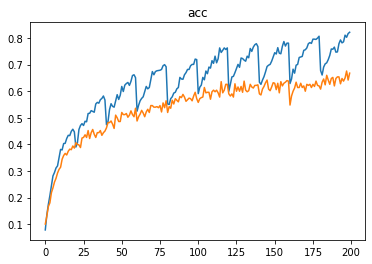

In [38]:
#展示accuracy和loss的變化
logs = history_all

plt.plot(logs['accuracy'])
plt.plot(logs['val_accuracy'])
plt.title('acc')


Text(0.5, 1.0, 'loss')

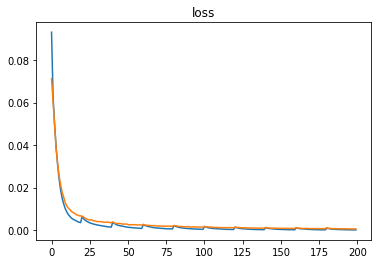

In [39]:
plt.plot(logs['loss'])
plt.plot(logs['val_loss'])
plt.title('loss')